In [19]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

In [20]:
def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
def logsumexp(a, axis=None, b=None, keepdims=False, return_sign=False):
    
    a = _asarray_validated(a, check_finite=False)
    if b is not None:
        a, b = np.broadcast_arrays(a, b)
        if np.any(b == 0):
            a = a + 0.  # promote to at least float
            a[b == 0] = -np.inf

    a_max = np.amax(a, axis=axis, keepdims=True)

    if a_max.ndim > 0:
        a_max[~np.isfinite(a_max)] = 0
    elif not np.isfinite(a_max):
        a_max = 0

    if b is not None:
        b = np.asarray(b)
        tmp = b * np.exp(a - a_max)
    else:
        tmp = np.exp(a - a_max)

    # suppress warnings about log of zero
    with np.errstate(divide='ignore'):
        s = np.sum(tmp, axis=axis, keepdims=keepdims)
        if return_sign:
            sgn = np.sign(s)
            s *= sgn  # /= makes more sense but we need zero -> zero
        out = np.log(s)

    if not keepdims:
        a_max = np.squeeze(a_max, axis=axis)
    out += a_max

    if return_sign:
        return out, sgn
    else:
        return out
def _asarray_validated(a, check_finite=True,
                       sparse_ok=False, objects_ok=False, mask_ok=False,
                       as_inexact=False):
    if not sparse_ok:
        import scipy.sparse
        if scipy.sparse.issparse(a):
            msg = ('Sparse matrices are not supported by this function. '
                   'Perhaps one of the scipy.sparse.linalg functions '
                   'would work instead.')
            raise ValueError(msg)
    if not mask_ok:
        if np.ma.isMaskedArray(a):
            raise ValueError('masked arrays are not supported')
    toarray = np.asarray_chkfinite if check_finite else np.asarray
    a = toarray(a)
    if not objects_ok:
        if a.dtype is np.dtype('O'):
            raise ValueError('object arrays are not supported')
    if as_inexact:
        if not np.issubdtype(a.dtype, np.inexact):
            a = toarray(a, dtype=np.float_)
    return a

In [23]:
# helper function

def value_iteration(theta=0.0001, discount_factor=1.0):
    policy_list = []

    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []

    for _ in range(1):
        iter += 1
        print(iter)
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = best_action_value
        print(V)
        vl.append(V.copy())
        dl.append(delta)

        # Check if we can stop
        print("debug-> iter={}, delta={:.5f}, V={}".format(iter, delta, V))
#         if delta < theta:
#             break
        # Create a deterministic policy using the optimal value function
        policy_iter = np.zeros([nS, nA])
        for s in range(nS):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            print(A)
            # pdb.set_trace()
            policy_t = softmax(A)
            best_action = np.argmax(A)
            # Always take the best action
            # policy_iter[s, best_action] = 1.0
            # soft policy
            policy_iter[s, :] = policy_t # record action values
        policy_list.append(policy_iter)
        # print("policy", policy_iter)

    # Create a deterministic policy using the optimal value function
    policy = np.zeros([nS, nA])
    for s in range(nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        print(A)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0

    return policy, V, dl, vl, policy_list, A

In [ ]:
def mean_reward( policy_list):
    # mean reward for agent 1
    discount_factor = 1.
    v1 = []
    iter = len(policy_list)
    for idx in range(iter):
        # pdb.set_trace()
        policy = policy_list[idx]
        v1_t = []
        for s in range(env.nS):
            vs = 0.
            for a in range(env.nA):
                # a_taken = np.argmax(policy[s]) # 1
                vs += policy[s][a]*R1[s][a]
            v1_t.append(vs)
        v1.append(v1_t)
    # pdb.set_trace()
    v1 = np.array(v1)
    x = np.arange(0,iter)

    plt.plot(x, v1.sum(-1), linewidth=1.8)
    plt.scatter(x, v1.sum(-1), marker='o')
    #
    plt.xlabel('#Iter')
    plt.ylabel('Mean reward for #1')

    plt.show()

    # mean reward for agent 2
    discount_factor = 1.
    v1 = []
    iter = len(policy_list)
    for idx in range(iter):
        policy = policy_list[idx]
        v1_t = []
        for s in range(env.nS):
            vs = 0.
            for a in range(env.nA):
                # a_taken = np.argmax(policy[s]) # 1
                vs += policy[s][a]*R2[s][a]
            v1_t.append(vs)
        v1.append(v1_t)
    # pdb.set_trace()
    v1 = np.array(v1)
    x = np.arange(0,iter)
    plt.plot(x, v1.sum(-1), linewidth=1.8)
    plt.scatter(x, v1.sum(-1), marker='o')
    #
    plt.xlabel('#Iter')
    plt.ylabel('Mean reward for #2')
    plt.show()

In [97]:
def P_comp(n, node_N):

    nS = int(2 + ((node_N - 2)/2) * (n + 1))
    print(nS)
    nA = 2**n
    P = dict()
    for s in range(nS):
        P[s] = {a : [] for a in range(nA)}

    for state in range(nS):
        for a in range(nA):
            tmp = []
            prob = 1
            snext = transition[state][a]
            reward = payoff[state][a]
            done = False
            if snext == (nS -1):
                done = True
            # prob, next_state, reward, done
            tmp.extend([(prob, int(snext), reward, done)])
            P[state][a] = tmp
        print(P)
            
    return nS, nA, P

## 1. Small one

In [ ]:
# just for record
graph = {
    "0": {"1": lambda x : x,            "0": lambda x : 2},
    "1": {"1": lambda x : 1,        "0": lambda x : x},
    "2": {"1": lambda x : 1,        "0": lambda x : x},
    "3": {"1": lambda x : 10,        "0": lambda x: x},
    "4": {"1": lambda x : 1,           "0": 10},
    "5": {"1": lambda x : 0,            "0": 0},
} 

In [3]:
# 2 agents; small
# payoff matrix

nS = 8
nA = 3

payoff = [
    [-3, -3, -4], # [s,s]
    [-2, -2, -3], # [a,a]
    [-2, -2, -2], # [a,b]
    [-2, -2, -3], # [b,b]
    [-3, -10, -10], # [c,c]
    [-10, -2, -10], # [c,d]
    [-10, -10, -2],  # [d,d]
    [0, 0, 0]     # [T,T]
]
transition =[
    [1, 2, 3],
    [4, 5, 6],
    [4, 5, 6],
    [4, 5, 6],
    [7, 7, 7],
    [7, 7, 7],
    [7, 7, 7],
    [7, 7, 7]
]

In [4]:
P = dict()
for s in range(nS):
    P[s] = {a : [] for a in range(nA)}
    
for state in range(nS):
    for a in range(nA):
        tmp = []
        prob = 1
        snext = transition[state][a]
        reward = payoff[state][a]
        done = False
        if snext == 10:
            done = True
        # prob, next_state, reward, done
        tmp.extend([(prob, snext, reward, done)])
        P[state][a] = tmp
P

{0: {0: [(1, 1, -3, False)], 1: [(1, 2, -3, False)], 2: [(1, 3, -4, False)]},
 1: {0: [(1, 4, -2, False)], 1: [(1, 5, -2, False)], 2: [(1, 6, -3, False)]},
 2: {0: [(1, 4, -2, False)], 1: [(1, 5, -2, False)], 2: [(1, 6, -2, False)]},
 3: {0: [(1, 4, -2, False)], 1: [(1, 5, -2, False)], 2: [(1, 6, -3, False)]},
 4: {0: [(1, 7, -3, False)], 1: [(1, 7, -10, False)], 2: [(1, 7, -10, False)]},
 5: {0: [(1, 7, -10, False)], 1: [(1, 7, -2, False)], 2: [(1, 7, -10, False)]},
 6: {0: [(1, 7, -10, False)], 1: [(1, 7, -10, False)], 2: [(1, 7, -2, False)]},
 7: {0: [(1, 7, 0, False)], 1: [(1, 7, 0, False)], 2: [(1, 7, 0, False)]}}

In [17]:
policy, V, dl, vl, policy_list, A = value_iteration()

1
debug-> iter=1, delta=3.00000, V=[-3. -2. -2. -2. -3. -2. -2.  0.]
2
debug-> iter=2, delta=2.00000, V=[-5. -4. -4. -4. -3. -2. -2.  0.]
3
debug-> iter=3, delta=2.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
4
debug-> iter=4, delta=0.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
5
debug-> iter=5, delta=0.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
6
debug-> iter=6, delta=0.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
7
debug-> iter=7, delta=0.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
8
debug-> iter=8, delta=0.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
9
debug-> iter=9, delta=0.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
10
debug-> iter=10, delta=0.00000, V=[-7. -4. -4. -4. -3. -2. -2.  0.]
[-7. -7. -8.]
[-5. -4. -5.]
[-5. -4. -4.]
[-5. -4. -5.]
[ -3. -10. -10.]
[-10.  -2. -10.]
[-10. -10.  -2.]
[0. 0. 0.]


In [18]:
policy_list

[array([[4.22318798e-01, 4.22318798e-01, 1.55362403e-01],
        [2.11941558e-01, 5.76116885e-01, 2.11941558e-01],
        [1.55362403e-01, 4.22318798e-01, 4.22318798e-01],
        [2.11941558e-01, 5.76116885e-01, 2.11941558e-01],
        [9.98179556e-01, 9.10221936e-04, 9.10221936e-04],
        [3.35237708e-04, 9.99329525e-01, 3.35237708e-04],
        [3.35237708e-04, 3.35237708e-04, 9.99329525e-01],
        [3.33333333e-01, 3.33333333e-01, 3.33333333e-01]]),
 array([[4.22318798e-01, 4.22318798e-01, 1.55362403e-01],
        [2.11941558e-01, 5.76116885e-01, 2.11941558e-01],
        [1.55362403e-01, 4.22318798e-01, 4.22318798e-01],
        [2.11941558e-01, 5.76116885e-01, 2.11941558e-01],
        [9.98179556e-01, 9.10221936e-04, 9.10221936e-04],
        [3.35237708e-04, 9.99329525e-01, 3.35237708e-04],
        [3.35237708e-04, 3.35237708e-04, 9.99329525e-01],
        [3.33333333e-01, 3.33333333e-01, 3.33333333e-01]]),
 array([[4.22318798e-01, 4.22318798e-01, 1.55362403e-01],
        [2

In [102]:
policy

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

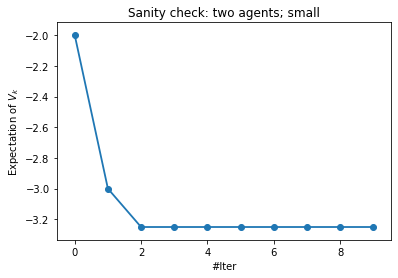

In [103]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 10)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('Expectation of $V_k$')
plt.title("Sanity check: two agents; small")
plt.show()

## 2. bigger one

In [ ]:
# just for record
graph = {
    "0": {"1": lambda x : x,            "0": lambda x : 2},
    "1": {"1": lambda x : 1,        "0": lambda x : x},
    "2": {"1": lambda x : 1,        "0": lambda x : x},
    "3": {"1": lambda x : 1,        "0": lambda x : x},
    "4": {"1": lambda x : 1,        "0": lambda x : x},
    "5": {"1": lambda x : 10,        "0": lambda x: x},
    "6": {"1": lambda x : 1,           "0": 10},
    "7": {"1": lambda x : 0,            "0": 0},
} 

In [105]:
# 2 agents; big
# payoff matrix

nS = 11
nA = 3

payoff = [
    [-3, -3, -4], # [b,b] 5
    [-2, -2, -2], # [b,e] 6
    [-2, -2, -2],  # [e,e] 7
    [-3, -10, -10], # [c,c] 8
    [-10, -2, -10], # [c,f] 9
    [-10, -10, -2], # [f,f] 10
    [0, 0, 0]      #[T,T] 11
]
transition =[
    [1, 2, 3],
    [4, 5, 6],
    [4, 5, 6],
    [4, 5, 6],
    [7, 8, 9],
    [7, 8, 9],
    [7, 8, 9],
    [10,10,10],
    [10, 10, 10],
    [10, 10, 10],
    [10, 10, 10]
]

In [106]:
P = dict()
for s in range(nS):
    P[s] = {a : [] for a in range(nA)}
    
for state in range(nS):
    for a in range(nA):
        tmp = []
        prob = 1
        snext = transition[state][a]
        reward = payoff[state][a]
        done = False
        if snext == 10:
            done = True
        # prob, next_state, reward, done
        tmp.extend([(prob, snext, reward, done)])
        P[state][a] = tmp
P

{0: {0: [(1, 1, -3, False)], 1: [(1, 2, -3, False)], 2: [(1, 3, -4, False)]},
 1: {0: [(1, 4, -2, False)], 1: [(1, 5, -2, False)], 2: [(1, 6, -3, False)]},
 2: {0: [(1, 4, -2, False)], 1: [(1, 5, -2, False)], 2: [(1, 6, -2, False)]},
 3: {0: [(1, 4, -2, False)], 1: [(1, 5, -2, False)], 2: [(1, 6, -3, False)]},
 4: {0: [(1, 7, -3, False)], 1: [(1, 8, -3, False)], 2: [(1, 9, -4, False)]},
 5: {0: [(1, 7, -2, False)], 1: [(1, 8, -2, False)], 2: [(1, 9, -2, False)]},
 6: {0: [(1, 7, -2, False)], 1: [(1, 8, -2, False)], 2: [(1, 9, -2, False)]},
 7: {0: [(1, 10, -3, True)], 1: [(1, 10, -10, True)], 2: [(1, 10, -10, True)]},
 8: {0: [(1, 10, -10, True)], 1: [(1, 10, -2, True)], 2: [(1, 10, -10, True)]},
 9: {0: [(1, 10, -10, True)], 1: [(1, 10, -10, True)], 2: [(1, 10, -2, True)]},
 10: {0: [(1, 10, 0, True)], 1: [(1, 10, 0, True)], 2: [(1, 10, 0, True)]}}

In [107]:
policy, V, dl, vl, policy_list, A = value_iteration()

1
debug-> iter=1, delta=3.00000, V=[-3. -2. -2. -2. -3. -2. -2. -3. -2. -2.  0.]
2
debug-> iter=2, delta=2.00000, V=[-5. -4. -4. -4. -5. -4. -4. -3. -2. -2.  0.]
3
debug-> iter=3, delta=2.00000, V=[-7. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
4
debug-> iter=4, delta=2.00000, V=[-9. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
5
debug-> iter=5, delta=0.00000, V=[-9. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
6
debug-> iter=6, delta=0.00000, V=[-9. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
7
debug-> iter=7, delta=0.00000, V=[-9. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
8
debug-> iter=8, delta=0.00000, V=[-9. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
9
debug-> iter=9, delta=0.00000, V=[-9. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
10
debug-> iter=10, delta=0.00000, V=[-9. -6. -6. -6. -5. -4. -4. -3. -2. -2.  0.]
[ -9.  -9. -10.]
[-7. -6. -7.]
[-7. -6. -6.]
[-7. -6. -7.]
[-6. -5. -6.]
[-5. -4. -4.]
[-5. -4. -4.]
[ -3. -10. -10.]
[-10.  -2. -10.]
[-10. -10.  -2.]
[0. 0. 0.]


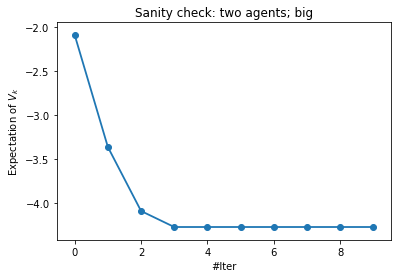

In [108]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 10)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('Expectation of $V_k$')
plt.title("Sanity check: two agents; big")
plt.show()

In [ ]:
policy, v, dl, vl, policy_list = spg_vi.value_iteration(env)

    print("Policy Probability Distribution:", policy)
    print("Value Function:", v)

    # plot Bk
    # Bk(dl,vl)
    # plot mean reward
    mean_reward(policy_list)
    # # plot state values or total returns
    total_return(policy_list)